In [1]:
# 1. Install dependencies (Colab only)
!pip install pyspark==3.5.0 delta-spark==3.1.0 -q

# 2. Import libraries and configure Spark with Delta
from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession
import os
import shutil

builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# 3. Create sample DataFrame
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

# 4. Save data to Delta format at a location
delta_path = "/tmp/orders_delta"
df.write.format("delta").mode("overwrite").save(delta_path)

# 5. Create MANAGED table (Spark controls data location)
spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql("CREATE TABLE orders_managed USING DELTA LOCATION '{}'".format(delta_path))

# 6. Create UNMANAGED table (also points to same location)
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")
spark.sql("CREATE TABLE orders_unmanaged USING DELTA LOCATION '{}'".format(delta_path))

print("Initial data in managed table:")
spark.sql("SELECT * FROM orders_managed").show()

print("Initial data in unmanaged table:")
spark.sql("SELECT * FROM orders_unmanaged").show()

# 7. Drop managed table and check if data still exists
spark.sql("DROP TABLE orders_managed")
print("After dropping MANAGED table, Delta files still exist:", os.path.exists(delta_path))

# 8. Drop unmanaged table and check data location
spark.sql("DROP TABLE orders_unmanaged")
print("After dropping UNMANAGED table, Delta files still exist:", os.path.exists(delta_path))

# 9. Manually delete the Delta files to clean up
if os.path.exists(delta_path):
    shutil.rmtree(delta_path)
    print("Delta files manually deleted.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 315.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.
Initial data in managed table:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

Initial data in unmanaged table:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amo

In [2]:

# 1. Install dependencies (only in Colab)
!pip install pyspark==3.5.0 delta-spark==3.1.0 -q

from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# 2. Create Spark Session with Delta support
builder = (
    SparkSession.builder.appName("DeltaCRUD")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# 3. Create sample initial data
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df = spark.createDataFrame(data, columns)

# 4. Save as Delta table
delta_path = "/tmp/orders_delta_crud"
df.write.format("delta").mode("overwrite").save(delta_path)
spark.sql(f"DROP TABLE IF EXISTS orders_crud")
spark.sql(f"CREATE TABLE orders_crud USING DELTA LOCATION '{delta_path}'")

# -------------------
# READ
# -------------------
print("Initial data:")
spark.sql("SELECT * FROM orders_crud").show()

# -------------------
# UPDATE: All "Clothing" category → amount = amount + 20
# -------------------
spark.sql("""
UPDATE orders_crud
SET amount = amount + 20
WHERE category = 'Clothing'
""")

print("After UPDATE:")
spark.sql("SELECT * FROM orders_crud").show()

# -------------------
# DELETE: Remove orders with quantity < 2
# -------------------
spark.sql("""
DELETE FROM orders_crud
WHERE quantity < 2
""")

print("After DELETE:")
spark.sql("SELECT * FROM orders_crud").show()

# -------------------
# MERGE: Insert new rows & update existing rows
# -------------------
# New dataset with one existing order (to update) and one new order (to insert)
new_data = [
    (3, "Mike", "Electronics", 5, 750),   # existing order_id = 3 → update
    (5, "Alex", "Furniture", 1, 200)      # new order_id = 5 → insert
]
df_new = spark.createDataFrame(new_data, columns)
df_new.createOrReplaceTempView("new_orders")

spark.sql("""
MERGE INTO orders_crud AS target
USING new_orders AS source
ON target.order_id = source.order_id
WHEN MATCHED THEN
  UPDATE SET *
WHEN NOT MATCHED THEN
  INSERT *
""")

print("After MERGE:")
spark.sql("SELECT * FROM orders_crud").show()


Initial data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

After UPDATE:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+

After DELETE:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+-

In [3]:
# 1. Check Delta table history
print("Delta table history:")
spark.sql("DESCRIBE HISTORY orders_crud").show(truncate=False)

# 2. Read from version 0 (initial state)
print("Data from version 0:")
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load(delta_path)
df_v0.show()

# 3. Read latest version
print("Data from latest version:")
df_latest = spark.read.format("delta").load(delta_path)
df_latest.show()

# 4. Compare row-by-row (optional Pandas diff)
import pandas as pd
pdf_v0 = df_v0.toPandas()
pdf_latest = df_latest.toPandas()

print("\nDifferences between version 0 and latest:")
comparison = pdf_latest.merge(pdf_v0, how='outer', indicator=True)
print(comparison)


Delta table history:
+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---------------------

Final Delta table after incremental load:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       5|         Alex|Electronics|       1|   200|
|       6|         Emma|   Clothing|       2|   100|
+--------+-------------+-----------+--------+------+

Starting streaming read (will run for ~15 seconds)...


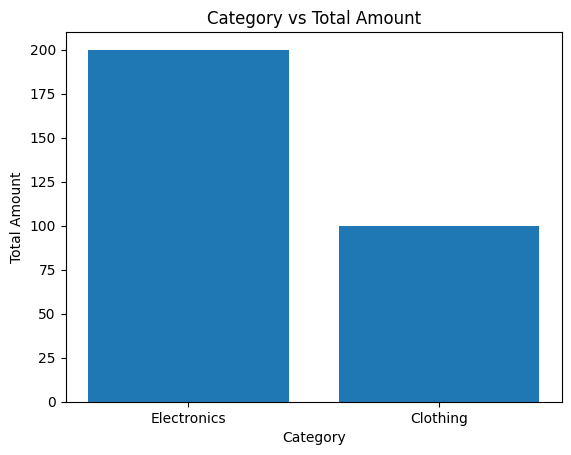

In [4]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
import pandas as pd
import matplotlib.pyplot as plt
import time

# ==============================
# Spark + Delta setup
# ==============================
builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

delta_path = "/tmp/orders_delta"

# ==============================
# 4. Incremental Load Pattern
# ==============================
new_data = [
    (5, "Alex", "Electronics", 1, 200),
    (6, "Emma", "Clothing", 2, 100),
]
new_columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df_new = spark.createDataFrame(new_data, new_columns)

# Append new data
df_new.write.format("delta").mode("append").save(delta_path)

print("Final Delta table after incremental load:")
spark.read.format("delta").load(delta_path).show()

# ==============================
# 5. Simple Streaming Read
# ==============================
print("Starting streaming read (will run for ~15 seconds)...")
stream_df = (
    spark.readStream.format("delta")
    .load(delta_path)
)

query = (
    stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Let the stream run for 15 seconds
time.sleep(15)
query.stop()

# ==============================
# 6. Visualization
# ==============================
df_final = spark.read.format("delta").load(delta_path)
pdf = df_final.groupBy("category").sum("amount").toPandas()

# Rename for clarity
pdf.columns = ["category", "total_amount"]

# Plot
plt.bar(pdf["category"], pdf["total_amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
